In [2]:
import pandas as pd
# Importing XGBClassifier for the XGBoost model
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
# We now import RandomizedSearchCV instead of GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV 
# We need scipy.stats for defining parameter distributions
from scipy.stats import uniform, randint
import numpy as np

# --- Configuration ---
# Number of random parameter combinations to test.
# This gives better coverage than the fixed grid search.
N_ITER_SEARCH = 50 
# ---------------------

# --- 1. Load Data ---
# We use a try/except block to handle file loading errors gracefully.
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    sample_submission_df = pd.read_csv('sample_submission.csv')
except FileNotFoundError as e:
    print(f"Error: One or more files not found. Ensure 'train.csv', 'test.csv', and 'sample_submission.csv' are available. {e}")
    exit()

print("Data loaded successfully.")

# Separate IDs needed for the final submission file
test_ids = test_df['id']

# Remove the 'id' column from both dataframes as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1) 

# --- 2. Separate Features (X) and Target (y) ---
X = train_df.drop('WeightCategory', axis=1)
y = train_df['WeightCategory']

# --- 3. Data Cleaning, Imputation, and Feature Engineering (NEW STEP) ---
print("3. Feature Engineering and Imputation...")

# Identify columns by type
numerical_cols_raw = X.select_dtypes(include=np.number).columns
categorical_cols_raw = X.select_dtypes(include=['object']).columns

# A. Calculate BMI: Weight / (Height^2). This is highly predictive.
def calculate_bmi(df):
    # Replace zero height with a tiny number (1e-6) to prevent division by zero
    df['Height'] = df['Height'].replace(0, 1e-6) 
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    return df

# Apply BMI calculation to both datasets
X = calculate_bmi(X)
test_df = calculate_bmi(test_df)
print("   -> Added highly predictive 'BMI' feature.")

# B. Imputation: Fill missing values
# Imputation for Numerical Features: Fill missing values with the median (robust to outliers)
for col in numerical_cols_raw:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)
    test_df[col] = test_df[col].fillna(median_val)

# Imputation for Categorical Features: Fill missing values with 'Missing'
for col in categorical_cols_raw:
    X[col] = X[col].fillna('Missing')
    test_df[col] = test_df[col].fillna('Missing')
print("   -> Imputed missing values with median/Missing.")


# --- 4. Pre-processing: Handling Categorical Data (OHE) ---
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_test_processed = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align columns
missing_cols = set(X_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0
X_test_processed = X_test_processed[X_processed.columns]


# --- 5. Pre-processing: Feature Scaling ---
# The 'BMI' feature is automatically included here for scaling.
scaler = StandardScaler()
numerical_cols = X_processed.select_dtypes(include=[np.number]).columns.tolist()

X_processed[numerical_cols] = scaler.fit_transform(X_processed[numerical_cols])
X_test_processed[numerical_cols] = scaler.transform(X_test_processed[numerical_cols])


# --- 6. Target Encoding ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\n--- Target Class Mapping (for reference) ---")
for category, code in target_mapping.items():
    print(f"Code {code}: {category}")
print("-" * 40)


# --- 7. Hyperparameter Tuning using RandomizedSearchCV ---

print(f"Starting Randomized Hyperparameter Tuning with {N_ITER_SEARCH} total trials...")

# Define the parameter DISTRIBUTIONS to sample from
param_distributions = {
    # Number of trees: Test a wider, random range
    'n_estimators': randint(100, 700), 
    # Learning rate: Sample continuously between 0.005 and 0.2
    'learning_rate': uniform(0.005, 0.195), 
    # Tree depth: Sample integers between 3 and 10
    'max_depth': randint(3, 11), 
    # Subsample (row sampling): Sample between 0.5 and 1.0
    'subsample': uniform(0.5, 0.5),
    # Colsample (feature sampling): Sample between 0.5 and 1.0
    'colsample_bytree': uniform(0.5, 0.5), 
    # L2 regularization: Test a few discrete values
    'reg_lambda': [0.1, 1, 10]
}

# Initialize the base XGBoost model
base_model = XGBClassifier(
    objective='multi:softmax',
    use_label_encoder=False, 
    eval_metric='mlogloss',
    random_state=42
)

# Initialize RandomizedSearchCV
# We set n_iter=50 random combinations
# cv=3 means 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=base_model, 
    param_distributions=param_distributions, 
    n_iter=N_ITER_SEARCH, # Number of randomized trials
    scoring='accuracy', # The metric to optimize
    cv=3, 
    verbose=2, # Increased verbosity to track progress
    random_state=42, # Ensure reproducibility of the random sampling
    n_jobs=-1 # Use all available cores
)

# Perform the search
random_search.fit(X_processed, y_encoded)

# The best model found after tuning
model = random_search.best_estimator_

print("\nTuning complete.")
print(f"Total Randomized Trials: {N_ITER_SEARCH}")
print(f"Best parameters found: {random_search.best_params_}")


# --- 8. Evaluate on Training Data and Generate Predictions for the Test Set ---

# Calculate and print the training accuracy using the tuned model
y_train_pred_encoded = model.predict(X_processed)
train_accuracy = accuracy_score(y_encoded, y_train_pred_encoded)
print(f"Tuned Model Training Accuracy: {train_accuracy:.4f}")

print("Generating predictions on the test set...")
y_pred_encoded = model.predict(X_test_processed)

# Convert the numerical predictions back into the original category names
y_pred_categories = label_encoder.inverse_transform(y_pred_encoded)


# --- 9. Create Submission File ---

submission_df = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': y_pred_categories
})

# Save the final submission file
submission_filepath = 'submission_xgboost_random_search_bmi.csv' # Updated filename
submission_df.to_csv(submission_filepath, index=False)

print(f"\nSuccessfully generated predictions and saved to: {submission_filepath}")
print("\n--- Submission Head (First 5 Rows) ---")
print(submission_df.head().to_string(index=False))


Data loaded successfully.
3. Feature Engineering and Imputation...
   -> Added highly predictive 'BMI' feature.
   -> Imputed missing values with median/Missing.

--- Target Class Mapping (for reference) ---
Code 0: Insufficient_Weight
Code 1: Normal_Weight
Code 2: Obesity_Type_I
Code 3: Obesity_Type_II
Code 4: Obesity_Type_III
Code 5: Overweight_Level_I
Code 6: Overweight_Level_II
----------------------------------------
Starting Randomized Hyperparameter Tuning with 50 total trials...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\SANDEEP KUMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [13:49:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tuning complete.
Total Randomized Trials: 50
Best parameters found: {'colsample_bytree': np.float64(0.5909124836035503), 'learning_rate': np.float64(0.04076387942141959), 'max_depth': 6, 'n_estimators': 413, 'reg_lambda': 1, 'subsample': np.float64(0.5035331526098588)}
Tuned Model Training Accuracy: 0.9650
Generating predictions on the test set...

Successfully generated predictions and saved to: submission_xgboost_random_search_bmi.csv

--- Submission Head (First 5 Rows) ---
   id      WeightCategory
15533    Obesity_Type_III
15534  Overweight_Level_I
15535 Overweight_Level_II
15536     Obesity_Type_II
15537       Normal_Weight



--- EXPLORATORY DATA ANALYSIS (EDA) ---

🔹 Training Data Overview:
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC              

C:\Users\SANDEEP KUMAR\AppData\Local\Temp\ipykernel_50784\545486312.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WeightCategory', data=train_df, palette='viridis')


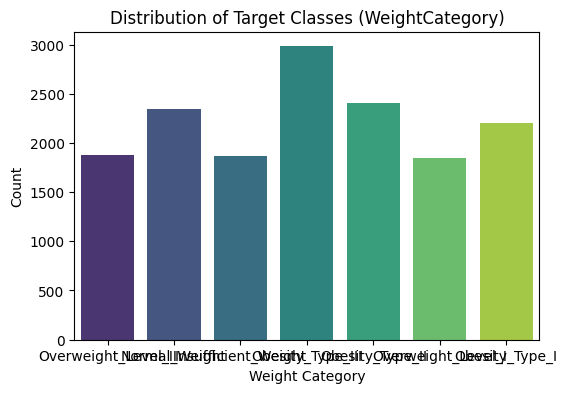

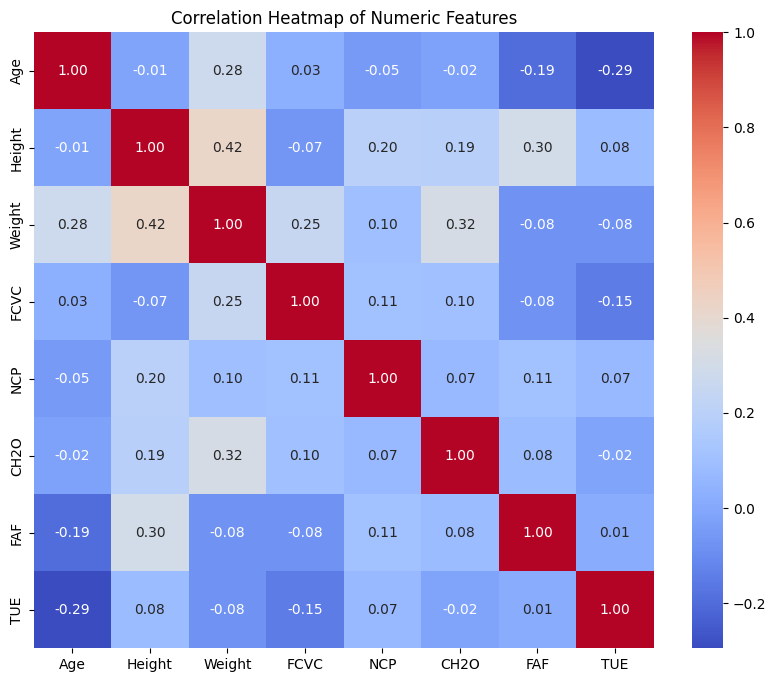


EDA Completed Successfully ✅



In [3]:
# --- 1.5 Exploratory Data Analysis (EDA) ---
print("\n--- EXPLORATORY DATA ANALYSIS (EDA) ---")

# 1. Dataset overview
print("\n🔹 Training Data Overview:")
print(train_df.head())

print("\n🔹 Shape of Train and Test Data:")
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

# 2. Data types and non-null counts
print("\n🔹 Data Info:")
print(train_df.info())

# 3. Missing value summary
print("\n🔹 Missing Values (Train):")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\n🔹 Missing Values (Test):")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

# 4. Statistical summary of numerical columns
print("\n🔹 Summary Statistics (Numerical Columns):")
print(train_df.describe().T)

# 5. Class distribution of target variable
print("\n🔹 Target Variable Distribution:")
print(train_df['WeightCategory'].value_counts(normalize=True) * 100)

# Optional visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# 6. Visualize target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='WeightCategory', data=train_df, palette='viridis')
plt.title("Distribution of Target Classes (WeightCategory)")
plt.xlabel("Weight Category")
plt.ylabel("Count")
plt.show()

# 7. Check correlation between numeric features
numeric_features = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 8. Example of pairplot (optional, good for smaller datasets)
# Uncomment below for deep visualization
# sns.pairplot(train_df, hue='WeightCategory')
# plt.show()

print("\nEDA Completed Successfully ✅\n")
